## Import necessary libs

In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import imutils
%matplotlib inline

In [144]:
df = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt",sep=" ", header=None)

In [145]:
df.drop(df.columns[-1],axis=1, inplace=True)
df.columns=["Name","labels","subset","x1","y1","x2","y2"]

In [146]:
df.head()

,Name,labels,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [147]:
len(df)

4536

In [155]:
# shuffle the datasets
df = df.sample(frac=1).reset_index(drop=True)

In [156]:
df.head()

,Name,labels,subset,x1,y1,x2,y2
0,3777915073.jpg,Fedex,4,39,151,109,224
1,18945268.jpg,Cocacola,3,167,177,245,223
2,2646033238.jpg,RedBull,6,38,4,486,422
3,3850753534.jpg,Sprite,4,122,199,211,261
4,18945268.jpg,Cocacola,4,3,326,63,362


In [157]:
df.describe()

,subset,x1,y1,x2,y2
count,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000
mean,4.277116,146.949074,120.966270,304.375000,231.778660
std,1.525430,122.357781,101.794867,122.789661,104.947444
min,1.000000,0.000000,0.000000,3.000000,17.000000
25%,3.000000,40.750000,29.750000,206.750000,156.000000
50%,5.000000,117.000000,102.000000,314.000000,231.000000
75%,6.000000,239.500000,189.250000,407.000000,308.250000
max,6.000000,469.000000,476.000000,500.000000,498.000000


In [158]:
df.loc[0]["Name"]

'3777915073.jpg'

In [150]:
def show_image(id):
    fig = plt.figure()
    image = os.path.join("./flickr_logos_27_dataset/flickr_logos_27_dataset_images/",df.loc[id]["Name"])
    image = cv2.imread(image)
    plt.figure(8)
    plt.imshow(image)
    currentAxis=plt.gca()
    rect=patches.Rectangle((df["x1"].iloc[id], df["y1"].iloc[id]),
                           df["x2"].iloc[id]-df["x1"].iloc[id],
                           df["y2"].iloc[id]-df["y1"].iloc[id],
                           linewidth=2,edgecolor='r',facecolor='none')
    currentAxis.add_patch(rect)

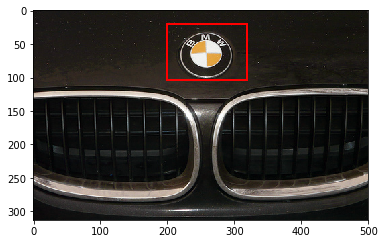

In [365]:
import random
id = random.randint(0,len(df))
show_image(id)


In [346]:
def crop_img(id):
    image = os.path.join("./flickr_logos_27_dataset/flickr_logos_27_dataset_images/",df.loc[id]["Name"])
    image = cv2.imread(image)
    crop_image = image[df["y1"].iloc[id]:df["y2"].iloc[id],df["x1"].iloc[id]:df["x2"].iloc[id]]
    return crop_image

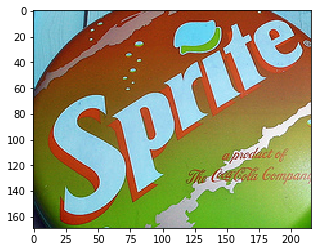

In [55]:
test = crop_img(id)
plt.imshow(test)

In [69]:
test.shape

(169, 216, 3)

In [159]:
WIDTH = 64
HEIGHT = 64

In [160]:
CLASSNAME = list(df["labels"].unique())

In [161]:
len(CLASSNAME)

27

## Crop Image and save them

In [162]:
class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# grab the dimensions of the image and then initialize
		# the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# if the width is smaller than the height, then resize
		# along the width (i.e., the smaller dimension) and then
		# update the deltas to crop the height to the desired
		# dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# otherwise, the height is smaller than the width so
		# resize along the height and then update the deltas
		# crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# now that our images have been resized, we need to
		# re-grab the width and height, followed by performing
		# the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# finally, resize the image to the provided spatial
		# dimensions to ensure our output image is always a fixed
		# size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [164]:
#asp = AspectAwarePreprocessor(WIDTH, HEIGHT)
for id, name in enumerate(df["Name"]):
    cropped_image = crop_img(id)
    try:
        resized_image = cv2.resize(cropped_image, (WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
        #resized_image = asp.preprocess(cropped_image)
    except:
        print(id)
        continue
    image_name = str(id)+"_"+df.iloc[id]["labels"]+".jpg"
    cv2.imwrite(os.path.join("./flickr_logos_27_dataset/cropped/",image_name),resized_image)
    

190
341
493
1252
3707


In [166]:
df.iloc[190]

Name      2662264721.jpg
labels           RedBull
subset                 3
x1                     3
y1                   197
x2                     3
y2                   197
Name: 190, dtype: object

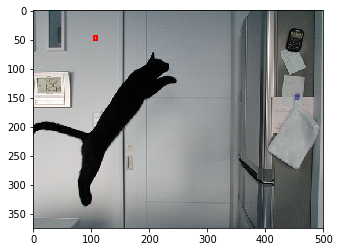

In [168]:
show_image(41)

## 数据增强

In [20]:
data = []
labels = []
HEIGHT = 64
WIDTH = 64
for img in os.listdir("./flickr_logos_27_dataset/cropped/"):
    img_file = cv2.imread(os.path.join("./flickr_logos_27_dataset/cropped/",img))
    data.append(img_file)
    labels.append(img.split("_")[1].split(".")[0])
data = np.stack(data)
labels = np.stack(labels)

In [21]:
len(data)
#len(labels)

4825

In [22]:
data.shape

(4825, 64, 64, 3)

In [23]:
data = data/255

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [25]:
from keras.utils import np_utils
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [26]:
labels[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [27]:
X,testX,y,testy = train_test_split(data, labels,test_size=0.1,stratify=labels,
                random_state=42 )

In [28]:
from keras.preprocessing.image import ImageDataGenerator 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=18, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

gen_flow=aug.flow(X, y,batch_size=64,seed=0)

In [29]:
X.shape

(4342, 64, 64, 3)

In [30]:
y.shape

(4342, 28)

## 模型定义

In [39]:
CLASSNAMES = list(lb.classes_)

In [40]:
len(CLASSNAMES)

28

In [41]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras import backend as K


model = Sequential()
inputShape = (HEIGHT, WIDTH, 3)
        # first set of CONV => RELU => POOL layers
model.add(Conv2D(16, (3, 3), padding="same",
    input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# third set of CONV => RELU => POOL layers
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dropout(0.25))
# softmax classifier
model.add(Dense(len(CLASSNAMES)))
model.add(Activation("softmax"))

In [433]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
activation_13 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [43]:
from keras.optimizers import Adam,SGD,RMSprop
#opt = Adam(lr=1e-2)
#opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
opt = RMSprop(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [44]:
# from callbacks import EpochCheckpoint
# from callbacks import TrainingMonitor
# # construct the set of callbacks
# callbacks = [
# 	EpochCheckpoint("./out", every=5,
# 		startAt=0),
# 	TrainingMonitor("./out", jsonPath="./out/monitor.json",
# 		startAt=0)]
# train the network
history=model.fit_generator(
	gen_flow,
	steps_per_epoch=len(X) // 64,
	validation_data=aug.flow(testX,testy,batch_size=64,seed=0),
	validation_steps=len(testX) // 64,
	epochs=150,
#callbacks=callbacks, 
    verbose=2)

Epoch 1/150
 - 10s - loss: 3.0111 - acc: 0.1882 - val_loss: 2.3564 - val_acc: 0.3482
Epoch 2/150
 - 7s - loss: 2.0657 - acc: 0.4082 - val_loss: 1.7392 - val_acc: 0.5155
Epoch 3/150
 - 7s - loss: 1.6183 - acc: 0.5343 - val_loss: 1.4335 - val_acc: 0.6014
Epoch 4/150
 - 7s - loss: 1.3625 - acc: 0.5949 - val_loss: 1.1726 - val_acc: 0.6420
Epoch 5/150
 - 6s - loss: 1.1706 - acc: 0.6519 - val_loss: 1.1813 - val_acc: 0.6611
Epoch 6/150
 - 6s - loss: 0.9949 - acc: 0.7043 - val_loss: 0.8447 - val_acc: 0.7709
Epoch 7/150
 - 6s - loss: 0.9046 - acc: 0.7271 - val_loss: 0.7817 - val_acc: 0.7661
Epoch 8/150
 - 6s - loss: 0.7901 - acc: 0.7725 - val_loss: 0.6519 - val_acc: 0.8067
Epoch 9/150
 - 7s - loss: 0.7209 - acc: 0.7868 - val_loss: 0.6956 - val_acc: 0.8214
Epoch 10/150
 - 8s - loss: 0.6337 - acc: 0.8071 - val_loss: 0.7748 - val_acc: 0.7924
Epoch 11/150
 - 7s - loss: 0.6053 - acc: 0.8217 - val_loss: 0.9213 - val_acc: 0.7446
Epoch 12/150
 - 7s - loss: 0.5321 - acc: 0.8416 - val_loss: 0.5589 - val_

Epoch 98/150
 - 7s - loss: 0.0948 - acc: 0.9754 - val_loss: 0.1724 - val_acc: 0.9570
Epoch 99/150
 - 7s - loss: 0.0951 - acc: 0.9746 - val_loss: 0.1624 - val_acc: 0.9785
Epoch 100/150
 - 7s - loss: 0.1079 - acc: 0.9721 - val_loss: 0.3004 - val_acc: 0.9547
Epoch 101/150
 - 7s - loss: 0.1115 - acc: 0.9732 - val_loss: 0.1997 - val_acc: 0.9570
Epoch 102/150
 - 8s - loss: 0.0949 - acc: 0.9724 - val_loss: 0.2000 - val_acc: 0.9523
Epoch 103/150
 - 8s - loss: 0.0913 - acc: 0.9761 - val_loss: 0.2169 - val_acc: 0.9618
Epoch 104/150
 - 7s - loss: 0.0905 - acc: 0.9756 - val_loss: 0.3152 - val_acc: 0.9523
Epoch 105/150
 - 6s - loss: 0.0883 - acc: 0.9748 - val_loss: 0.1700 - val_acc: 0.9643
Epoch 106/150
 - 7s - loss: 0.1047 - acc: 0.9750 - val_loss: 0.1524 - val_acc: 0.9666
Epoch 107/150
 - 8s - loss: 0.0874 - acc: 0.9764 - val_loss: 0.2841 - val_acc: 0.9451
Epoch 108/150
 - 7s - loss: 0.1055 - acc: 0.9769 - val_loss: 0.0530 - val_acc: 0.9785
Epoch 109/150
 - 7s - loss: 0.0920 - acc: 0.9764 - val_l

In [45]:
model.save("3_with_background.h5")

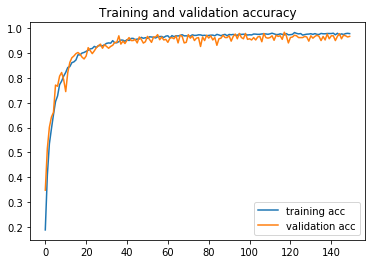

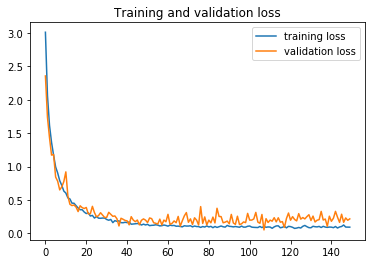

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc, label='training acc')
plt.plot(epochs,val_acc, label='validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss, label='training loss')
plt.plot(epochs,val_loss, label='validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test It

In [243]:
from keras.models import load_model  
model1 = load_model("1st_try.h5")

HP


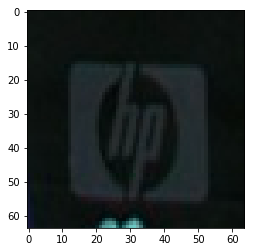

In [48]:
image_file = "./flickr_logos_27_dataset/cropped/434_HP.jpg"
img = cv2.imread(image_file)
img = img/255
#plt.imshow(img)
#img = mean_preprocess(img)
plt.imshow(img)

img = np.expand_dims(img,axis=0)
result = model.predict(img)

index = np.argmax(result[0])
label = CLASSNEAMES[int(index)]

print(label)

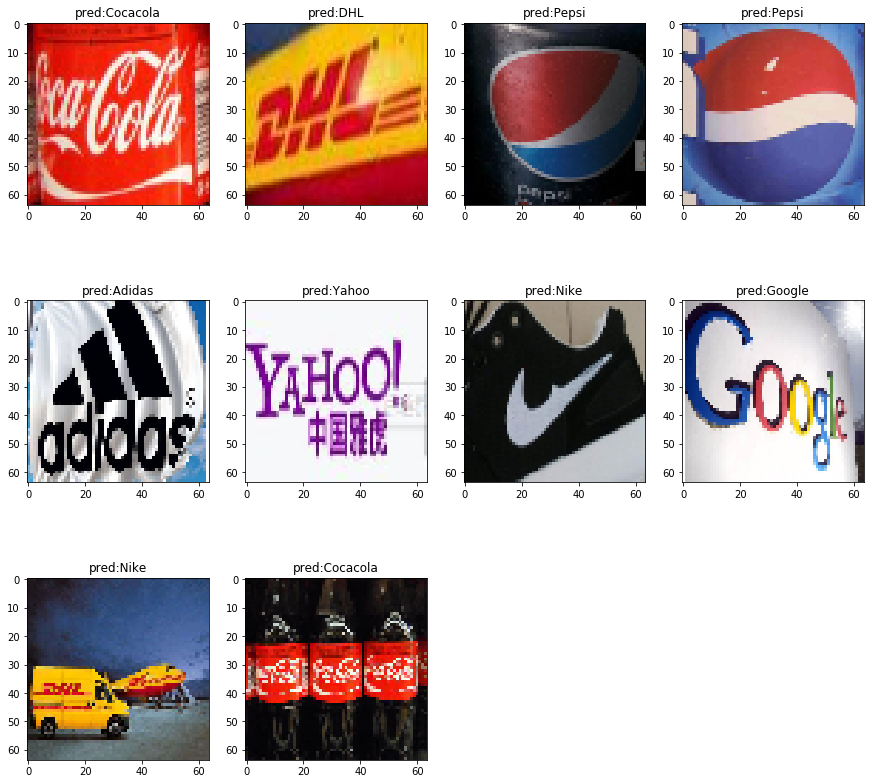

In [51]:
plt.figure(figsize = (15,40))
for i,test_img in enumerate(os.listdir("./test")):
    img = cv2.imread(os.path.join("./test",test_img))
    img = cv2.resize(img, (WIDTH,HEIGHT),interpolation=cv2.INTER_CUBIC)
    img = np.expand_dims(img,axis=0)
    result = model.predict(img)
    index = np.argmax(result[0])
    label = CLASSNEAMES[int(index)]
    plt.subplot(8,4, i+1)
    img = cv2.cvtColor(img[0],  cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('pred:' + str(label))

## 设计滑窗和特征金字塔

In [52]:
# initialize variables used for the object detection procedure
INPUT_SIZE = (300, 300)
PYR_SCALE = 1.5
WIN_STEP = 32
ROI_SIZE = (64, 64)

labels = {}
CLASSNAMES = list(lb.classes_)

In [53]:
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [54]:
def image_pyramid(image, scale=1.5, minSize=(64, 64)):
	# yield the original image
	yield image

	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

In [55]:
def logo_prediction(model, batchROIs, batchLocs, labels, minProb=0.5,dims=(64, 64)):
    preds = model.predict(batchROIs)
    for i in range(0,len(preds)):
        prob = np.max(preds[i])
        if prob > 0.5:
            index = np.argmax(preds[i])
            label = CLASS_NAMES[int(index)]
            # grab the coordinates of the sliding window for
            # the prediction and construct the bounding box
            (pX, pY) = batchLocs[i]
            box = (pX, pY, pX + dims[0], pY + dims[1])
            L = labels.get(label, [])
            L.append((box,prob))
            labels[label] = L
    return labels
    

In [56]:
img_file = "./test/1.jpg"
orig = cv2.imread(img_file)
# resize the input image to be a square
resized = cv2.resize(orig, INPUT_SIZE, interpolation=cv2.INTER_CUBIC)

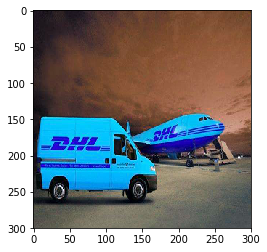

In [57]:
plt.imshow(resized)

In [58]:
# initialize the batch ROIs and (x, y)-coordinates
batchROIs = None
batchLocs = []
# loop over the image pyramid
for image in image_pyramid(resized, scale=PYR_SCALE,minSize=ROI_SIZE):
    # loop over the sliding window locations
    for (x, y, roi) in sliding_window(resized, WIN_STEP, ROI_SIZE):
        # take the ROI and pre-process it so we can later classify the
        # region with Keras
        #roi = img_to_array(roi)
        roi = roi/255
        roi = np.expand_dims(roi, axis=0)
        # roi = imagenet_utils.preprocess_input(roi)

        # if the batch is None, initialize it
        if batchROIs is None:
            batchROIs = roi

        # otherwise, add the ROI to the bottom of the batch
        else:
            batchROIs = np.vstack([batchROIs, roi])

        # add the (x, y)-coordinates of the sliding window to the batch
        batchLocs.append((x, y))


    # classify the batch, then reset the batch ROIs and
    # (x, y)-coordinates
    model.predict(batchROIs)
    labels = logo_prediction(model, batchROIs, batchLocs,labels, minProb=0.999999)

[INFO] Unicef: 8
[INFO] Background: 16
[INFO] DHL: 2
[INFO] Puma: 2


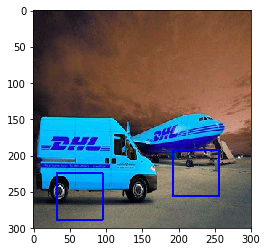

In [59]:
from imutils.object_detection import non_max_suppression
# loop over the labels for each of detected objects in the image
for k in labels.keys():
	# clone the input image so we can draw on it
	clone = resized.copy()

	# loop over all bounding boxes for the label and draw them on
	# the image
# 	for (box, prob) in labels[k]:
# 		(xA, yA, xB, yB) = box
# 		cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)

# 	# show the image *without* apply non-maxima suppression
# 	cv2.imshow("Without NMS", clone)
# 	clone = resized.copy()

	# grab the bounding boxes and associated probabilities for each
	# detection, then apply non-maxima suppression to suppress
	# weaker, overlapping detections
	boxes = np.array([p[0] for p in labels[k]])
	proba = np.array([p[1] for p in labels[k]])
	boxes = non_max_suppression(boxes, proba)

	# loop over the bounding boxes again, this time only drawing the
	# ones that were *not* suppressed
	for (xA, yA, xB, yB) in boxes:
		cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 0, 255), 2)

	# show the output image
	print("[INFO] {}: {}".format(k, len(boxes)))
	plt.imshow(clone)
	#cv2.waitKey(0)

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras import backend as K


model = Sequential()
inputShape = (HEIGHT, WIDTH, 3)
        # first set of CONV => RELU => POOL layers
model.add(Conv2D(16, (3, 3), padding="same",
    input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# third set of CONV => RELU => POOL layers
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dropout(0.25))
# softmax classifier
model.add(Dense(len(CLASSNAMES)))
model.add(Activation("softmax"))

TODO: 
1. 添加background 分类
2. 重做一个二分类问题

# 训练二分类网络
- 以识别coacla为例
- 参考自：Github：https://github.com/Anubhav-Bhargava/Logo-Classifier/blob/master/logo_clf_sliding_window.ipynb

In [9]:
import os, cv2
import numpy as np
data = []
labels = []
HEIGHT = 64
WIDTH = 64
for img in os.listdir("./flickr_logos_27_dataset/cropped/"):
    img_file = cv2.imread(os.path.join("./flickr_logos_27_dataset/cropped/",img))
    data.append(img_file)
    label = img.split("_")[1].split(".")[0]
    if label != "Pepsi":
        label = "Nop"
    labels.append(label)
data = np.stack(data)
labels = np.stack(labels)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(labels)
data = data / 255
X,testX,y,testy = train_test_split(data, y,test_size=0.1,stratify=y,
                random_state=42)

In [11]:
from keras.preprocessing.image import ImageDataGenerator 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=18, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

gen_flow=aug.flow(X, y,batch_size=64,seed=0)
val_flow=aug.flow(testX, testy, batch_size=64,seed=0)

In [18]:
CLASSNAMES = list(lb.classes_)
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras import backend as K


model = Sequential()
inputShape = (HEIGHT, WIDTH, 3)
        # first set of CONV => RELU => POOL layers
model.add(Conv2D(16, (3, 3), padding="same",
    input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# third set of CONV => RELU => POOL layers
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dropout(0.25))
# softmax classifier
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [19]:
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [20]:
history=model.fit_generator(
	gen_flow,
	steps_per_epoch=len(X) // 64,
	validation_data=aug.flow(testX,testy,batch_size=64,seed=0),
	validation_steps=len(testX) // 64,
	epochs=150,
#callbacks=callbacks, 
    verbose=2)

Epoch 1/150
 - 10s - loss: 0.2319 - acc: 0.9221 - val_loss: 0.1578 - val_acc: 0.9598
Epoch 2/150
 - 6s - loss: 0.1462 - acc: 0.9565 - val_loss: 0.1223 - val_acc: 0.9642
Epoch 3/150
 - 7s - loss: 0.1068 - acc: 0.9666 - val_loss: 0.0964 - val_acc: 0.9690
Epoch 4/150
 - 6s - loss: 0.0933 - acc: 0.9710 - val_loss: 0.0813 - val_acc: 0.9714
Epoch 5/150
 - 6s - loss: 0.0782 - acc: 0.9738 - val_loss: 0.0860 - val_acc: 0.9761
Epoch 6/150
 - 6s - loss: 0.0641 - acc: 0.9789 - val_loss: 0.0487 - val_acc: 0.9833
Epoch 7/150
 - 6s - loss: 0.0677 - acc: 0.9795 - val_loss: 0.1427 - val_acc: 0.9642
Epoch 8/150
 - 5s - loss: 0.0471 - acc: 0.9848 - val_loss: 0.0290 - val_acc: 0.9881
Epoch 9/150
 - 6s - loss: 0.0520 - acc: 0.9845 - val_loss: 0.0246 - val_acc: 0.9911
Epoch 10/150
 - 6s - loss: 0.0385 - acc: 0.9869 - val_loss: 0.0292 - val_acc: 0.9857
Epoch 11/150
 - 6s - loss: 0.0532 - acc: 0.9834 - val_loss: 0.0605 - val_acc: 0.9928
Epoch 12/150
 - 6s - loss: 0.0425 - acc: 0.9890 - val_loss: 0.0266 - val_

 - 6s - loss: 0.0355 - acc: 0.9951 - val_loss: 0.0385 - val_acc: 0.9978
Epoch 98/150
 - 7s - loss: 0.0107 - acc: 0.9984 - val_loss: 0.0800 - val_acc: 0.9928
Epoch 99/150
 - 6s - loss: 0.0190 - acc: 0.9965 - val_loss: 0.1313 - val_acc: 0.9690
Epoch 100/150
 - 6s - loss: 0.0241 - acc: 0.9960 - val_loss: 0.0770 - val_acc: 0.9952
Epoch 101/150
 - 7s - loss: 0.0188 - acc: 0.9953 - val_loss: 0.0557 - val_acc: 0.9952
Epoch 102/150
 - 7s - loss: 0.0220 - acc: 0.9956 - val_loss: 0.0699 - val_acc: 0.9857
Epoch 103/150
 - 7s - loss: 0.0061 - acc: 0.9991 - val_loss: 0.0770 - val_acc: 0.9952
Epoch 104/150
 - 6s - loss: 0.0201 - acc: 0.9967 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 105/150
 - 7s - loss: 0.0179 - acc: 0.9977 - val_loss: 0.0362 - val_acc: 0.9978
Epoch 106/150
 - 7s - loss: 0.0163 - acc: 0.9967 - val_loss: 0.0386 - val_acc: 0.9976
Epoch 107/150
 - 6s - loss: 0.0257 - acc: 0.9960 - val_loss: 2.9124e-05 - val_acc: 1.0000
Epoch 108/150
 - 6s - loss: 0.0235 - acc: 0.9963 - val_loss: 0.077

In [21]:
model.save("pepsi_detect.h5")

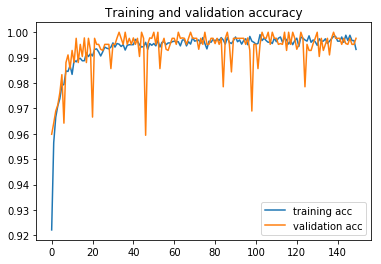

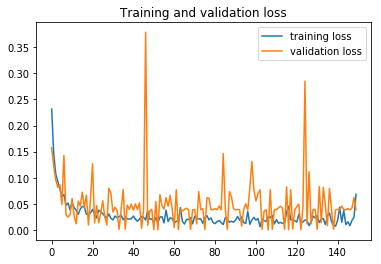

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc, label='training acc')
plt.plot(epochs,val_acc, label='validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss, label='training loss')
plt.plot(epochs,val_loss, label='validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()